# Shape Alignment using ICP and Global Transformation

In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

## Overview
In this problem, we write a function that aligns two sets of points using global image transformation (similarity, affine, or perspective) and returns $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$. You may choose the alignment algorithm and the type of (global) transformation (e.g., rigid Euclidean, affine, perspective).


<img src="https://drive.google.com/uc?id=1PnWIy9ZdP9SGkmGNtFCJ-JzKLwmW-qaN" width="1000"/>




## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
!unzip "/content/part2_images.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
To: /content/part2_images.zip
100% 78.4k/78.4k [00:00<00:00, 45.8MB/s]
Archive:  /content/part2_images.zip
replace /content/part2_images/Bone_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Helper Functions

In [ ]:
from scipy.ndimage.interpolation import rotate

def centreOfMass(img):
  indices = np.argwhere(img>0)
  COM = np.sum(indices, axis = 0)/indices.shape[0]
  return COM

def deviation(img):
  COM = centreOfMass(img)
  indices = np.argwhere(img>0)
  var = np.sqrt(np.sum((indices - COM)**2)/indices.shape[0])
  return var

def getMajorOrientation(im):
  #Creating an elongated gaussian and cross-correlating it with a x_gradient kernel
  sigma_y = 6
  size = sigma_y*4+1
  sigma_x = 1

  #Creating an elongated gaussian and cross-correlating it with a x_gradient kernel
  ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
  gauss_x = np.exp(-0.5 * np.square(ax) / np.square(sigma_x))
  gauss_y = np.exp(-0.5 * np.square(ax) / np.square(sigma_y))
  filter = np.outer(gauss_y, gauss_x)
  filter = filter/np.sum(filter)
  dx = np.array([[-1,0,1]])

  #Creating the bank of filters by rotating the resultant filter from the previous operation
  k0 = cv2.filter2D(filter, -1 ,dx)
  k45 = rotated = rotate(k0, angle=45, reshape=False)
  k90 = rotated = rotate(k0, angle=90, reshape=False)
  k135 = rotated = rotate(k0, angle=135, reshape=False)

  grad_0 = cv2.filter2D(im, -1, k0)
  grad_45 = cv2.filter2D(im, -1, k45)
  grad_90 = cv2.filter2D(im, -1, k90)
  grad_135 = cv2.filter2D(im, -1, k135)

  grad = np.array([np.mean(grad_0[im>0]), np.mean(grad_45[im>0]), np.mean(grad_90[im>0]), np.mean(grad_135[im>0])])
  orient = (np.pi/4)*np.argmax(grad)

  return orient

def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2) #distance transform
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1)
  err2 = np.mean(np.mean(d1[im2 > 0]))
  err = (err1+err2)/2;
  return err

def error(transformed, indices_2):
  # Defining error function
  err = 0
  for i in range(transformed.shape[0]):
          bin = transformed
          temp = bin[i,:]
          norm = indices_2.copy() 
          norm[:,:] = norm[:,:] - temp
          norm = np.linalg.norm(norm, axis=1)
          err = err + np.min(norm)
  return err/(transformed.shape[0])

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x) 
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time 
     thick: true if a line should be thickened for display
  ''' 
  if thick:
    # for thick lines (looks better for final display)
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    # for thin lines (faster)
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
  return dispim
  

In [ ]:
def visFromPoints(shape:tuple, points):
  img = np.zeros(shape)
  ax = np.floor(points[:,0:2])
  ax[ax<0] = 0

  for i in range(ax.shape[0]):
    m = ax[i,0]
    if m >= img.shape[1]:m = img.shape[1]-1
    n = ax[i,1]
    if n >= img.shape[0]:n = img.shape[0]-1
    img[int(n),int(m)] = 255

  # cv2_imshow(img)
  return img


## Code

In [ ]:
import time

imgPath = '/content/part2_images/';

objList = ['apple', 'bat', 'bell', 'bird', 'Bone', 'bottle', 'brick', \
    'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone', \
    'chicken', 'children', 'device7', 'dog', 'elephant', 'face', 'fork', 'hammer', \
    'Heart', 'horse', 'jar', 'turtle']

numObj = len(objList)

In [ ]:
def align_shape(im1, im2):
  '''
  im1: input edge image 1
  im2: input edge image 2

  Output: transformation T [3] x [3]
  '''
  # YOUR CODE HERE
  start_time = time.time()
  match_bank = []
  errors = []

  COM_1 = centreOfMass(im1)
  COM_2 = centreOfMass(im2)

  s = deviation(im2)/deviation(im1)

  indices_1 = np.argwhere(im1>0)
  indices_1[:,[0,1]] = indices_1[:,[1,0]]
  indices_1 = np.concatenate((indices_1, np.ones( (indices_1.shape[0],1) ) ), axis=1 )

  indices_2 = np.argwhere(im2>0)
  indices_2[:,[0,1]] = indices_2[:,[1,0]]
  indices_2 = np.concatenate((indices_2, np.ones( (indices_2.shape[0],1) ) ), axis=1 )

  origin_tr_1 =[-1*COM_1[0], -1*COM_1[1]]

  # Translate img_1's COM to (0,0)
  T1_origin = np.array([[1,0,origin_tr_1[1]], 
                        [0,1,origin_tr_1[0]],
                        [0,0,1]])

  # Scale img_1 to match the size of img_2
  T1_scale = np.array([ [s,0,0],
                        [0,s,0],
                        [0,0,1]])

  origin_tr_2 =[-1*COM_2[0], -1*COM_2[1]]

  # Translate img_1's COM from (0,0) to COM of img_2
  T2_origin = np.array([[1,0,origin_tr_2[1]], 
                        [0,1,origin_tr_2[0]],
                        [0,0,1]])

  T_1 = np.dot(T1_scale,T1_origin) #Pre multiplying the transformation matrices

  for z in range(2): #To account for mirroring

    if z == 1: #Mirroring in second z iteration
      mirroring = np.array([[-1,0,0],
                            [0,1,0],
                            [0,0,1]])
      
      T_1 = np.dot(mirroring,T_1) 

    for t in range(4): #Initializing with 8 different orientation for each mirroring
      init_rotation = np.array([[np.cos((np.pi*t)/2),-np.sin((np.pi*t)/2),0],
                                [np.sin((np.pi*t)/2),np.cos((np.pi*t)/2),0],
                                [0,0,1]])
      
      T_1 = np.dot(init_rotation, T_1)

      indices_1_T = np.dot(T_1, np.transpose(indices_1)) #Resultant Transformation to get the img_1's COM to (0,0) and scale img_1 to match img_2's size
      indices_2_T = np.dot(T2_origin, np.transpose(indices_2))
      indices_2_T = np.transpose(indices_2_T)

      transformed = indices_1_T
      nearest = np.zeros((indices_1.shape))

      iterations = 50
      transformation = 'Perspective' #Setting the transformation model 

      for k in range(iterations):

        if k != 0:
          transformed = np.dot(M,indices_1_T)

        # Iterative closest points

        for i in range(indices_1.shape[0]):
          bin = np.transpose(transformed)
          temp = bin[i,:]
          norm = indices_2_T.copy() 
          norm[:,:] = norm[:,:] - temp
          norm = np.linalg.norm(norm, axis=1)
          arg = np.argmin(norm)
          nearest[i,:] = indices_2_T[arg,:]

        # Solving for the affine/perspective transformation

        """
        Perspective Transformation:

        M = np.array([[m11, m12, m13],
                      [m21, m22, m23],
                      [m31, m32, 1]])

        8 degrees of freedom

        Affine Transformation:

        M = np.array([[m1, m2, t1]
                      [m3, m4, t2]
                      [0, 0, 1]])
        
        6 degrees of freedom
        """
        if transformation == 'Perspective':
          A = np.zeros((2*indices_1.shape[0], 8))
          b = np.zeros((2*indices_1.shape[0], 1))

          for i in range(0, 2*indices_1.shape[0], 2):
            j = int(i/2)
            x = np.transpose(transformed)[j,0]
            y = np.transpose(transformed)[j,1]
            x_ = nearest[j,0]
            y_ = nearest[j,1]
            A[i:i+2, :] = np.array([[x, y, 1, 0, 0, 0, -x*x_, -y*x_], 
                                    [0, 0, 0, x, y, 1, -x*y_, -y*y_]])
            b[i:i+2, :] = np.array([[x_],
                                    [y_]])
          m = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(A),A)), np.transpose(A)),b)

          M = np.array([[m[0][0], m[1][0], m[2][0]], #Perspective Transformation matrix
                        [m[3][0], m[4][0], m[5][0]],
                        [m[6][0], m[7][0], 1]])
            
        if transformation == 'Affine':
          A = np.zeros((2*indices_1.shape[0], 6))
          b = np.zeros((2*indices_1.shape[0], 1))

          for i in range(0, 2*indices_1.shape[0], 2):
            j = int(i/2)
            x = np.transpose(transformed)[j,0]
            y = np.transpose(transformed)[j,1]
            x_ = nearest[j,0]
            y_ = nearest[j,1]
            A[i:i+2, :] = np.array([[x, y, 0, 0, 1, 0], 
                                    [0, 0, x, y, 0, 1]])
            b[i:i+2, :] = np.array([[x_],
                                    [y_]])
            
          m = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(A),A)), np.transpose(A)),b)

          M = np.array([[m[0][0], m[1][0], m[4][0]], #Affine Transformation matrix
                        [m[2][0], m[3][0], m[5][0]],
                        [0, 0, 1]])

      T1_T2_translate = np.array([[1,0,COM_2[1]], 
                                  [0,1,COM_2[0]],
                                  [0,0,1]])
      
      T_matrix = np.dot(T1_T2_translate, M)
      transformed_pts = np.transpose(np.dot(T_matrix, indices_1_T))

      img = visFromPoints(im1.shape,transformed_pts)
      err = error(indices_2,transformed_pts)
      eval = evalAlignment(img, im2)
      dispim = displayAlignment(im2,im1,img)

      match_bank.append([dispim,eval])
      errors.append(err)

  min_error = np.argmin(np.array(errors))

  cv2_imshow(match_bank[min_error][0])

  print("Final error for best match = " + str(match_bank[min_error][1]))

  end_time = time.time()
  print("Execution time = " + str(end_time-start_time) + " seconds")

  pass

Visualizing the transformation results.
Left is the objective image, middle is the transformed image, right is the input image.

Results for apple :



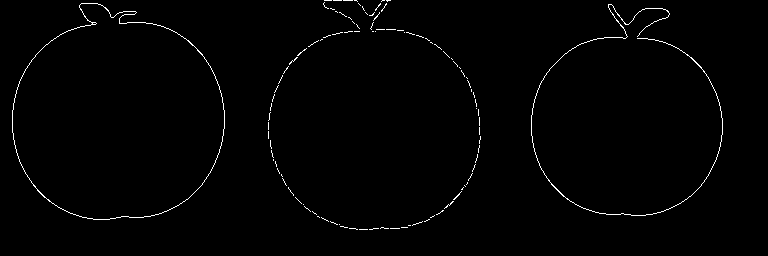

Final error for best match = 175.12017509265382
Execution time = 24.885836124420166 seconds

Results for bat :



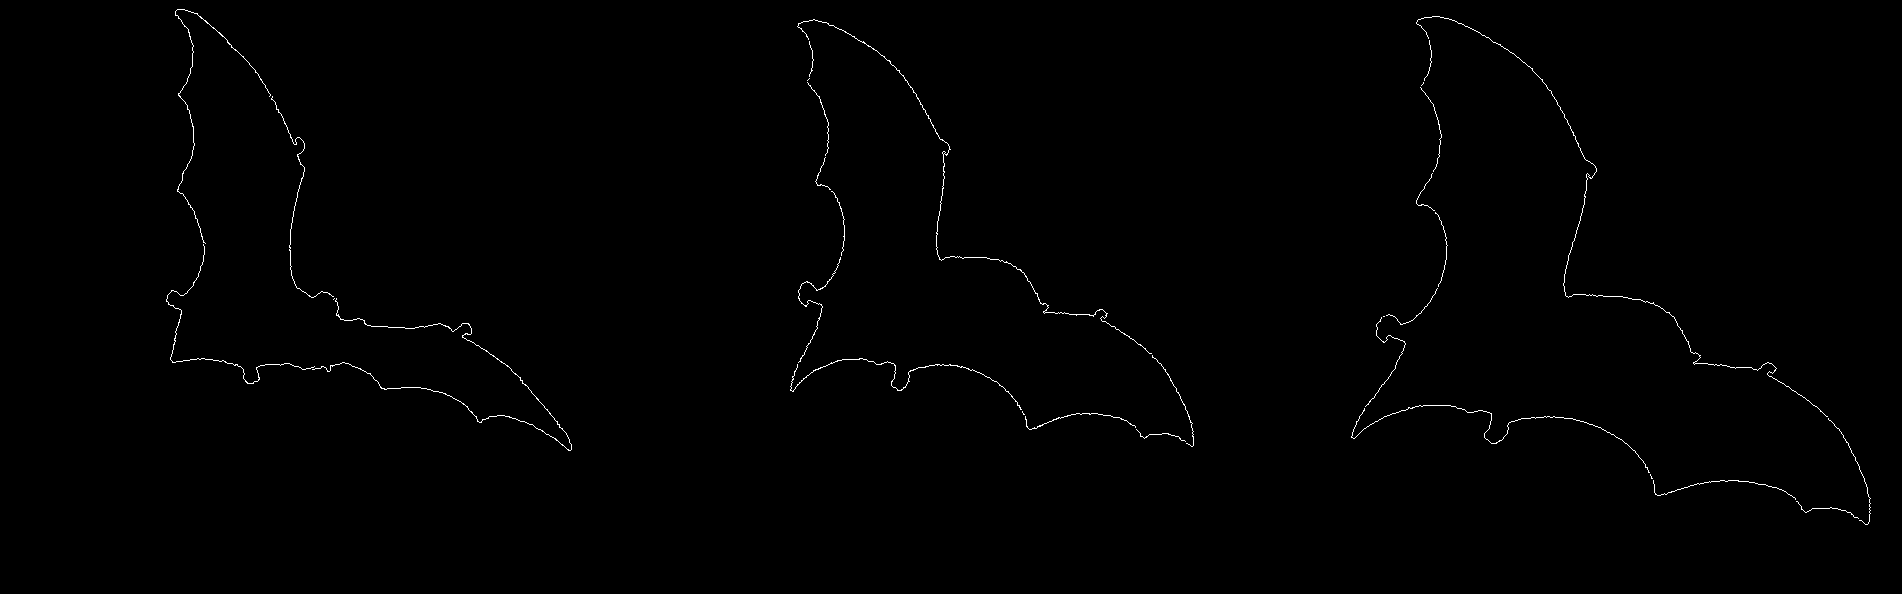

Final error for best match = 427.9053205693317
Execution time = 89.20952105522156 seconds

Results for bell :



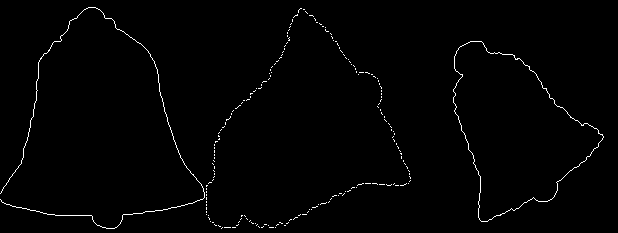

Final error for best match = 182.46355858887895
Execution time = 17.13178539276123 seconds

Results for bird :



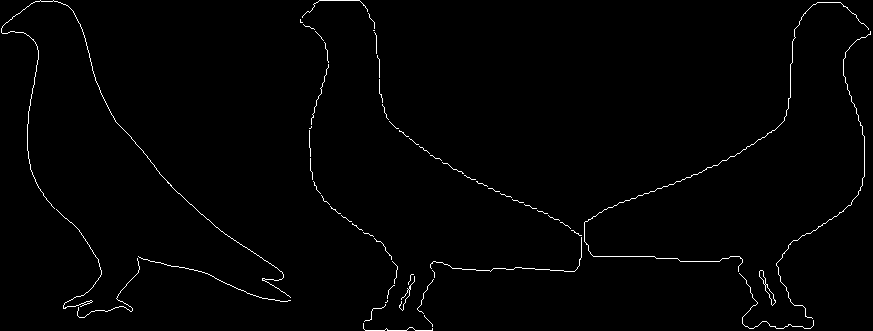

Final error for best match = 237.78408682665335
Execution time = 48.58216166496277 seconds

Results for Bone :



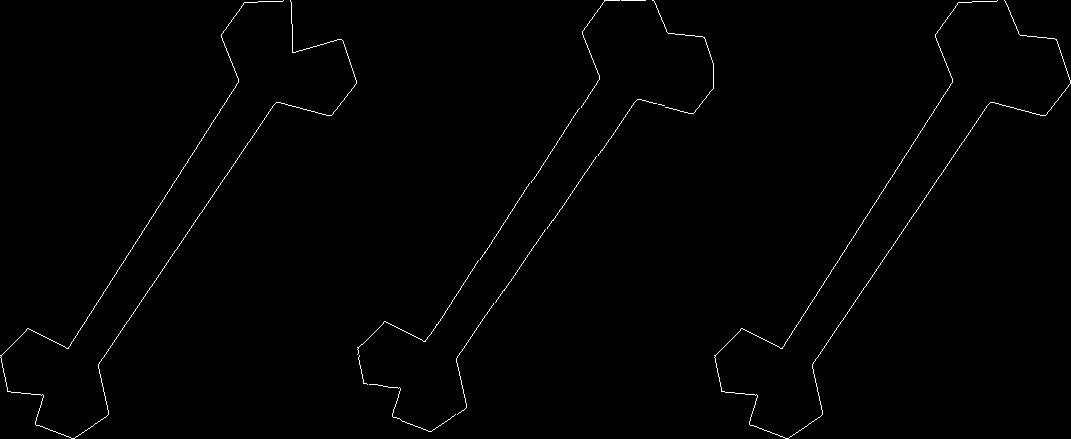

Final error for best match = 320.13240084560346
Execution time = 51.25518560409546 seconds

Results for bottle :



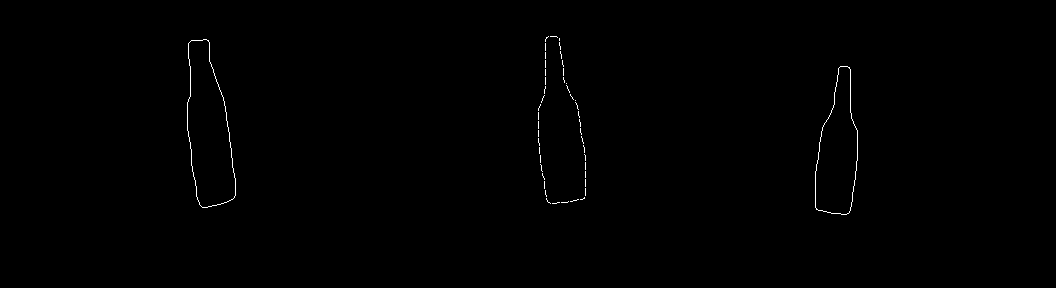

Final error for best match = 246.01918177870013
Execution time = 9.21740436553955 seconds

Results for brick :



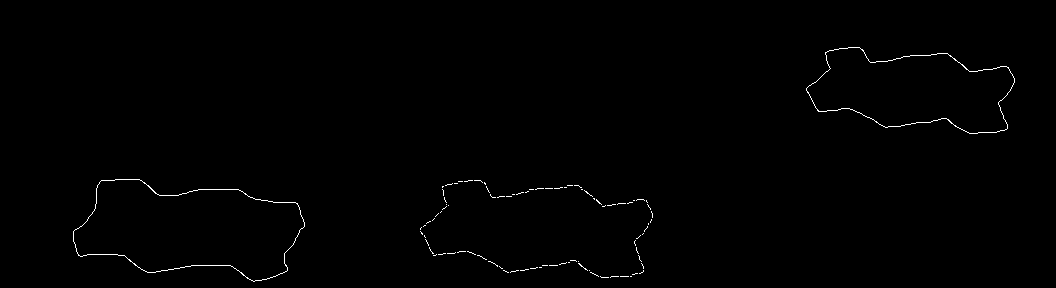

Final error for best match = 302.5938760680877
Execution time = 18.29954767227173 seconds

Results for butterfly :



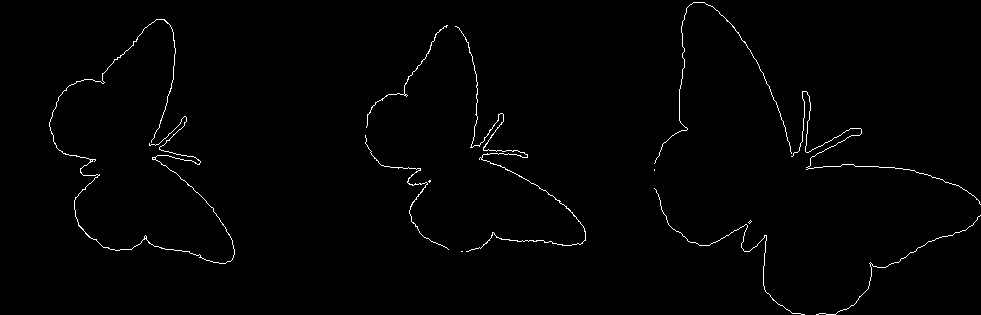

Final error for best match = 218.0692865886694
Execution time = 55.164247035980225 seconds

Results for camel :



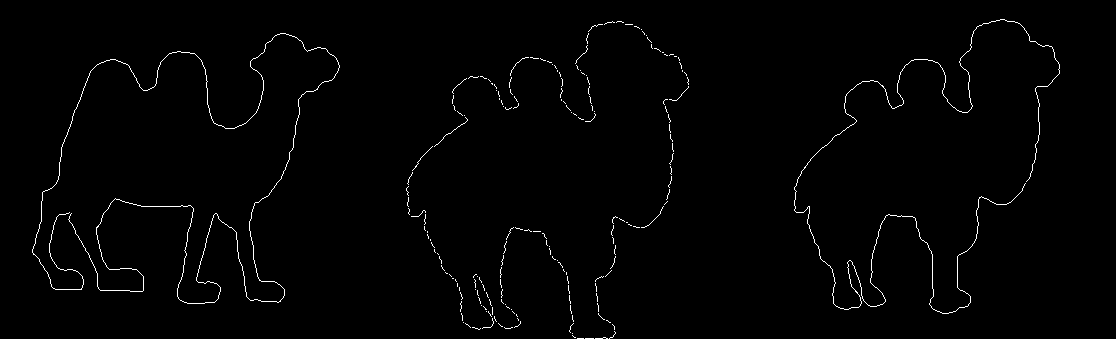

Final error for best match = 278.26717106948274
Execution time = 68.60931277275085 seconds

Results for car :



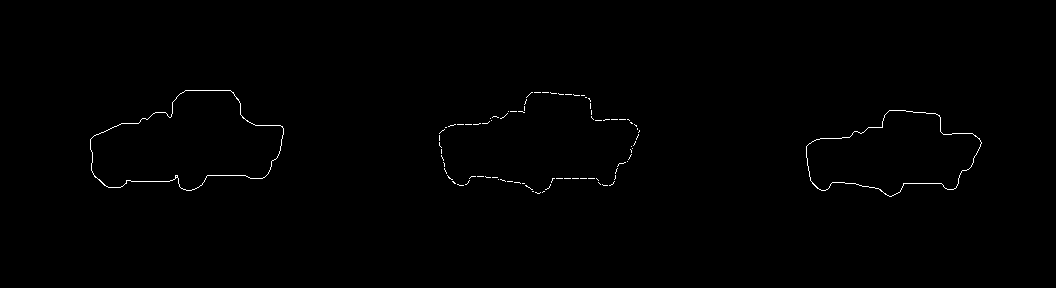

Final error for best match = 242.03324472821652
Execution time = 15.189488649368286 seconds

Results for carriage :



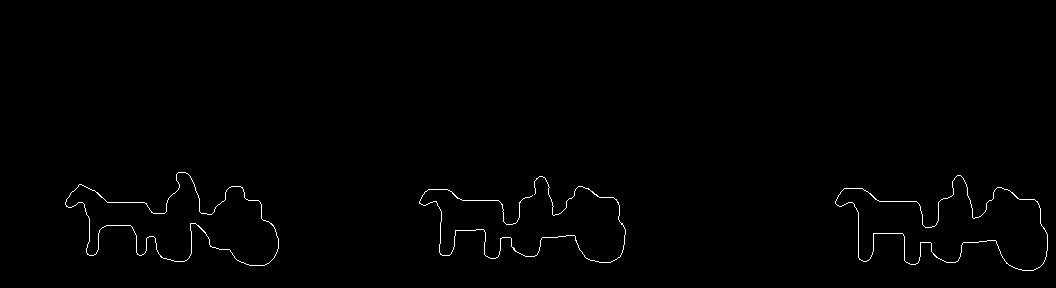

Final error for best match = 284.36470470411007
Execution time = 30.50913166999817 seconds

Results for cattle :



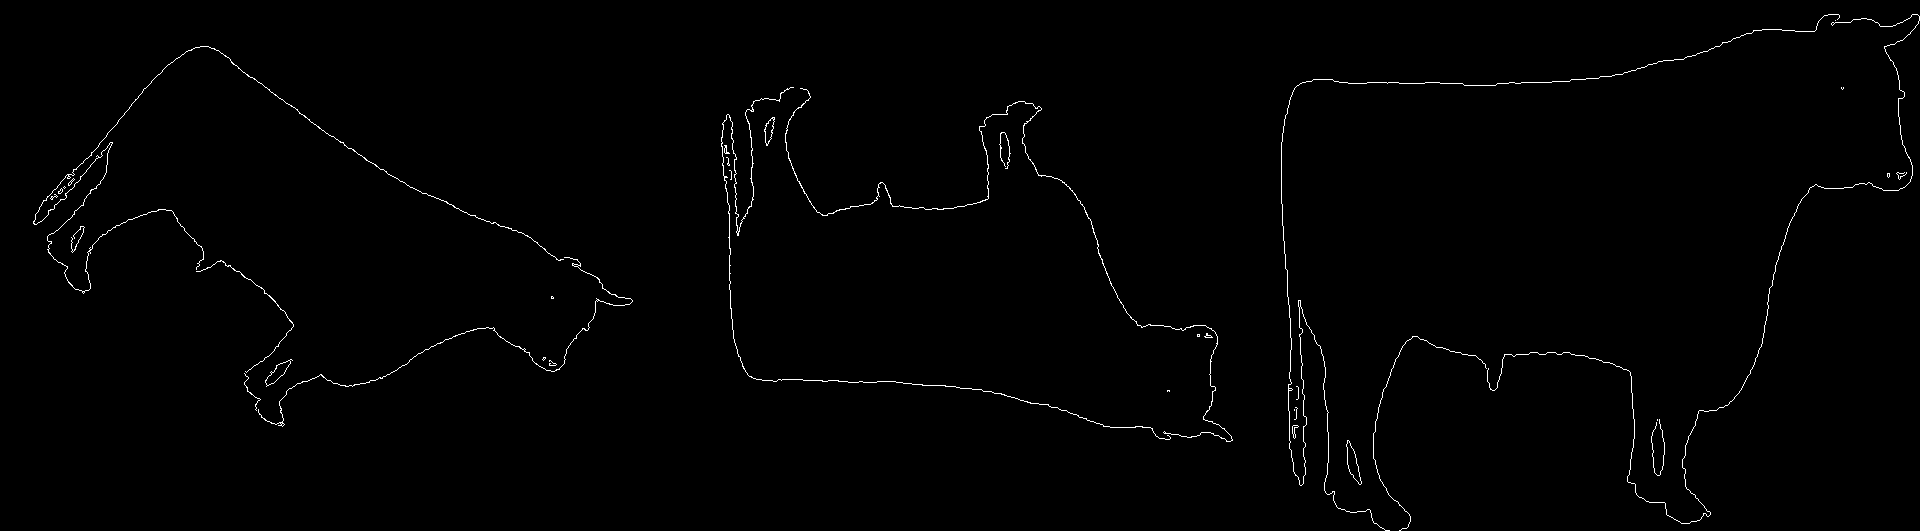

Final error for best match = 395.0082030293845
Execution time = 182.95248246192932 seconds

Results for cellular_phone :



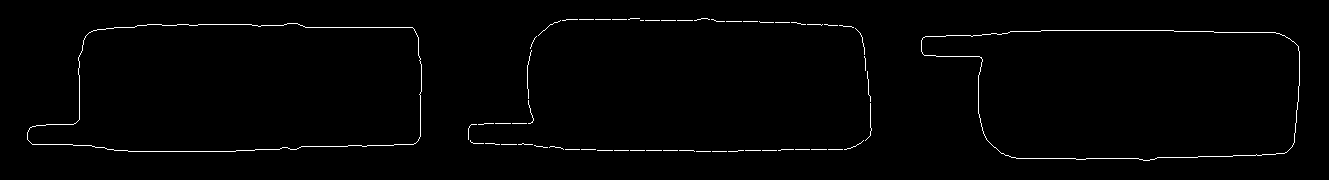

Final error for best match = 262.9232837129273
Execution time = 46.617507457733154 seconds

Results for chicken :



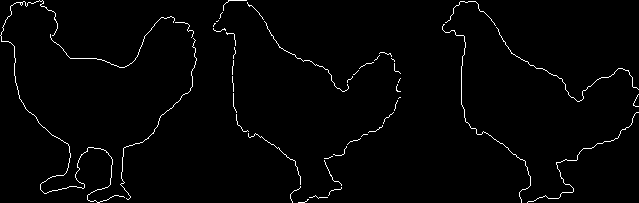

Final error for best match = 146.00657260450564
Execution time = 30.34513235092163 seconds

Results for children :



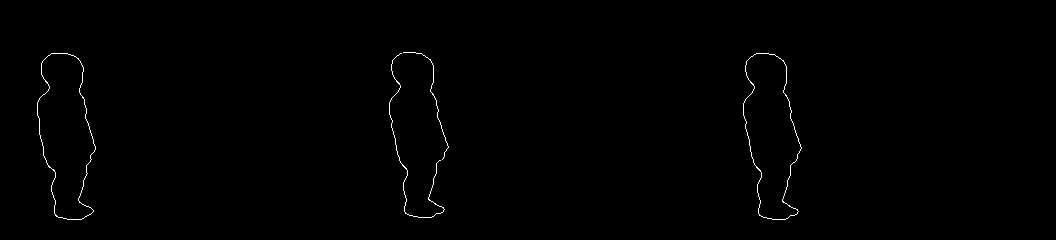

Final error for best match = 155.60566502924598
Execution time = 12.641490697860718 seconds

Results for device7 :



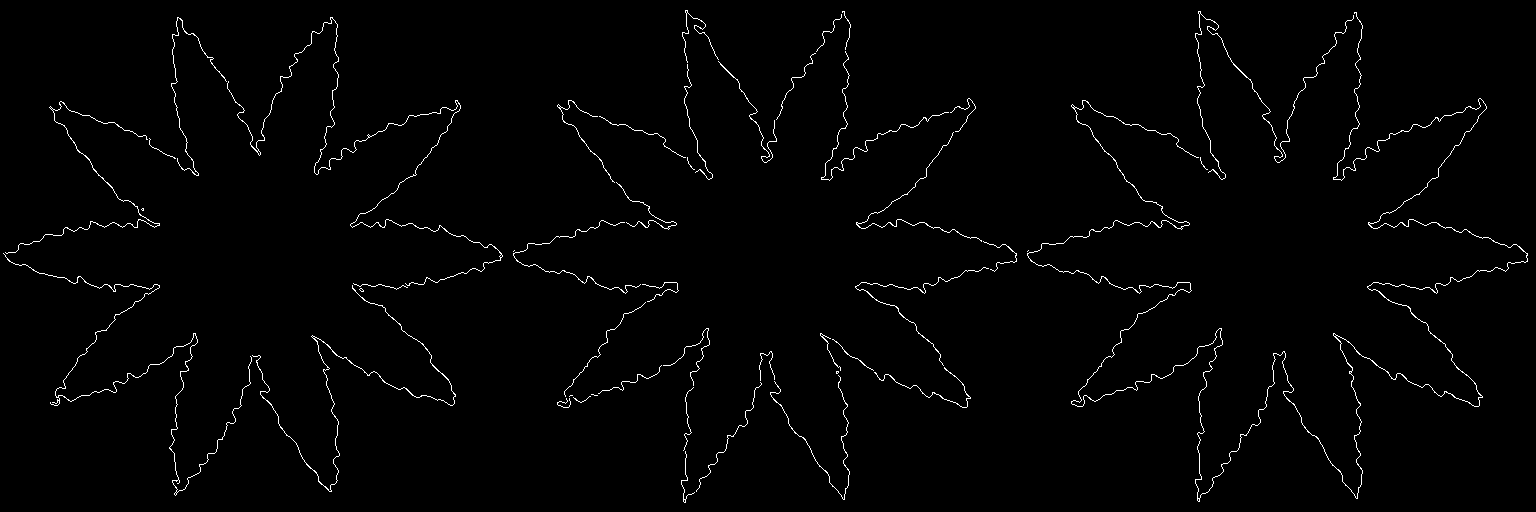

Final error for best match = 382.9881456509447
Execution time = 301.9047224521637 seconds

Results for dog :



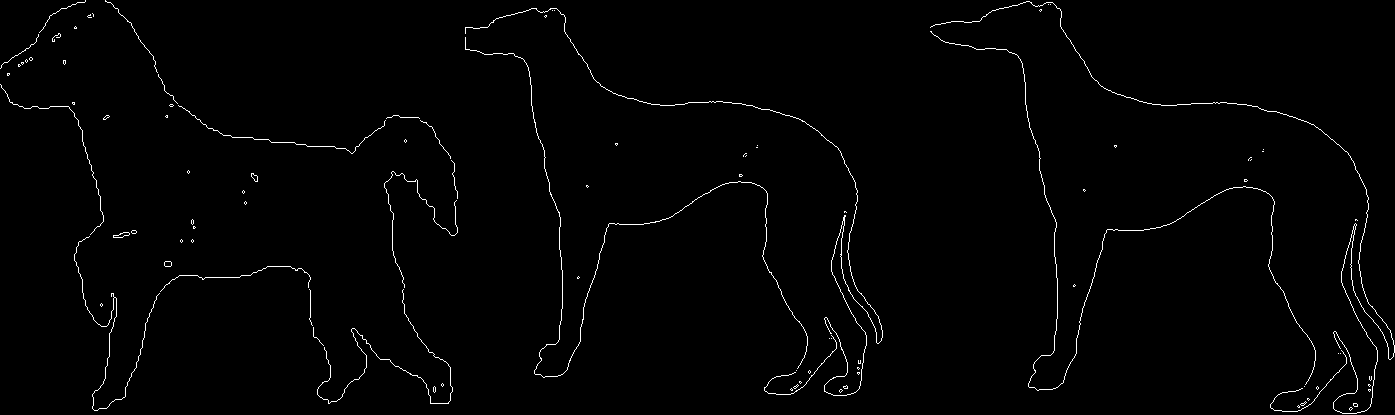

Final error for best match = 347.49518142852577
Execution time = 143.60575652122498 seconds

Results for elephant :



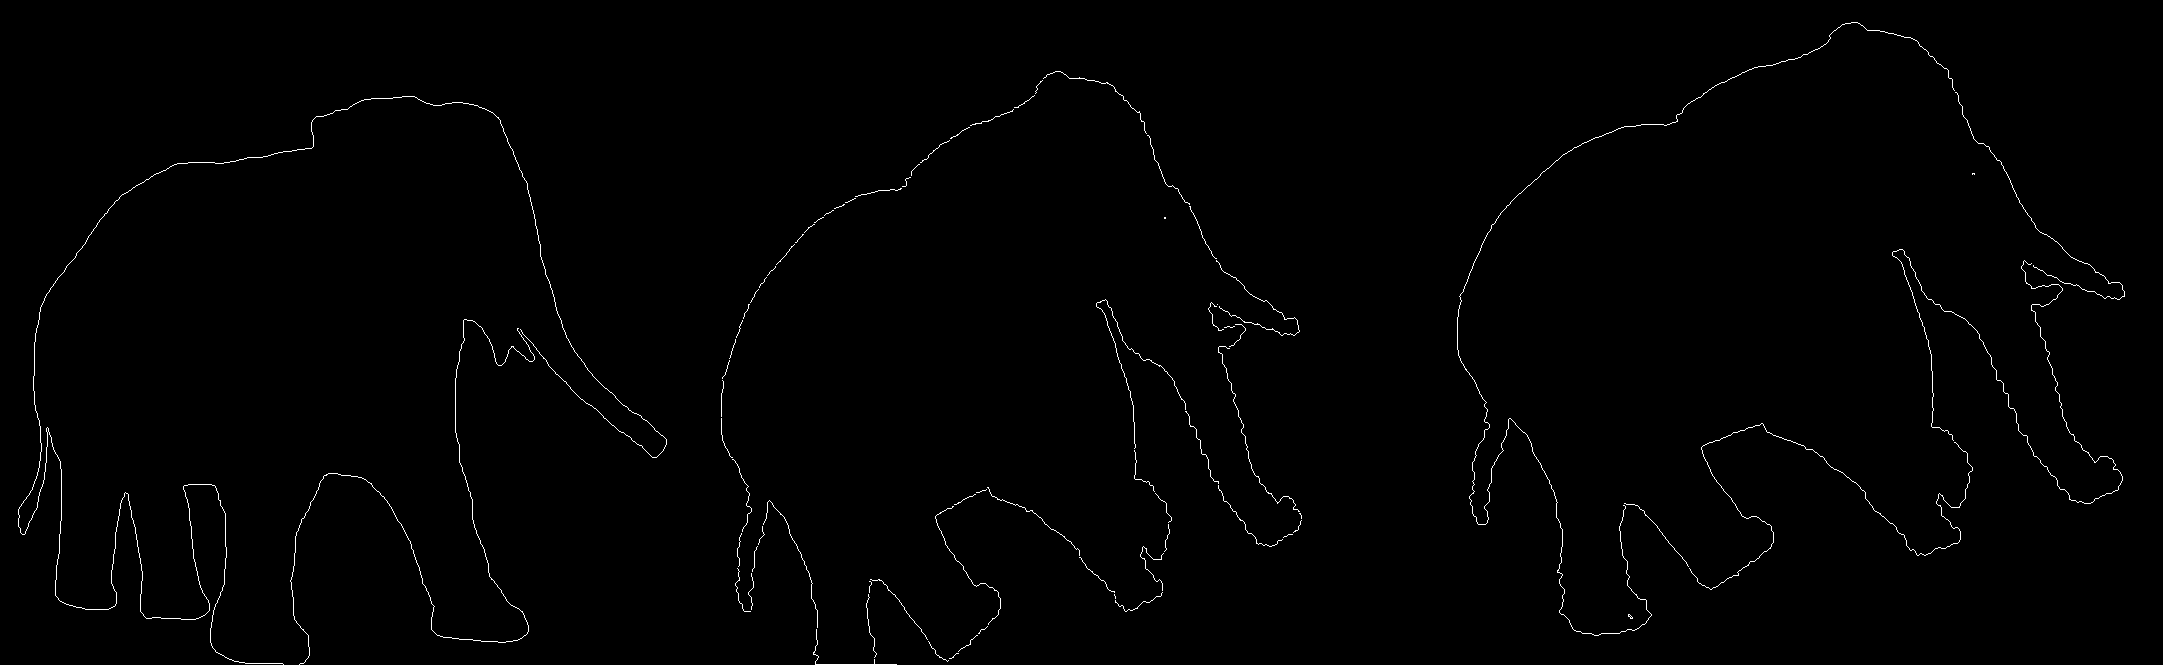

Final error for best match = 563.2464248161264
Execution time = 253.11993861198425 seconds

Results for face :



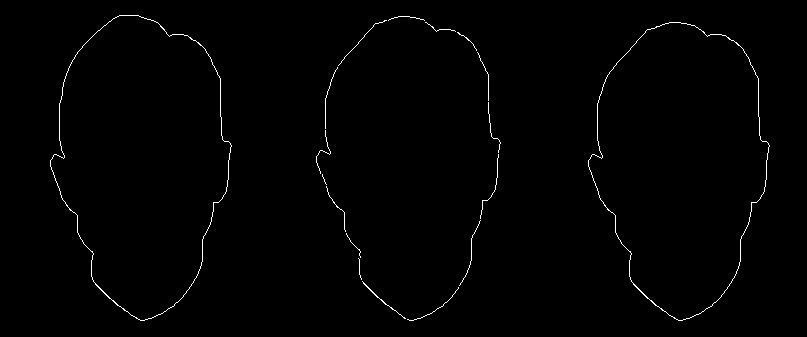

Final error for best match = 232.5270856608643
Execution time = 29.618401765823364 seconds

Results for fork :



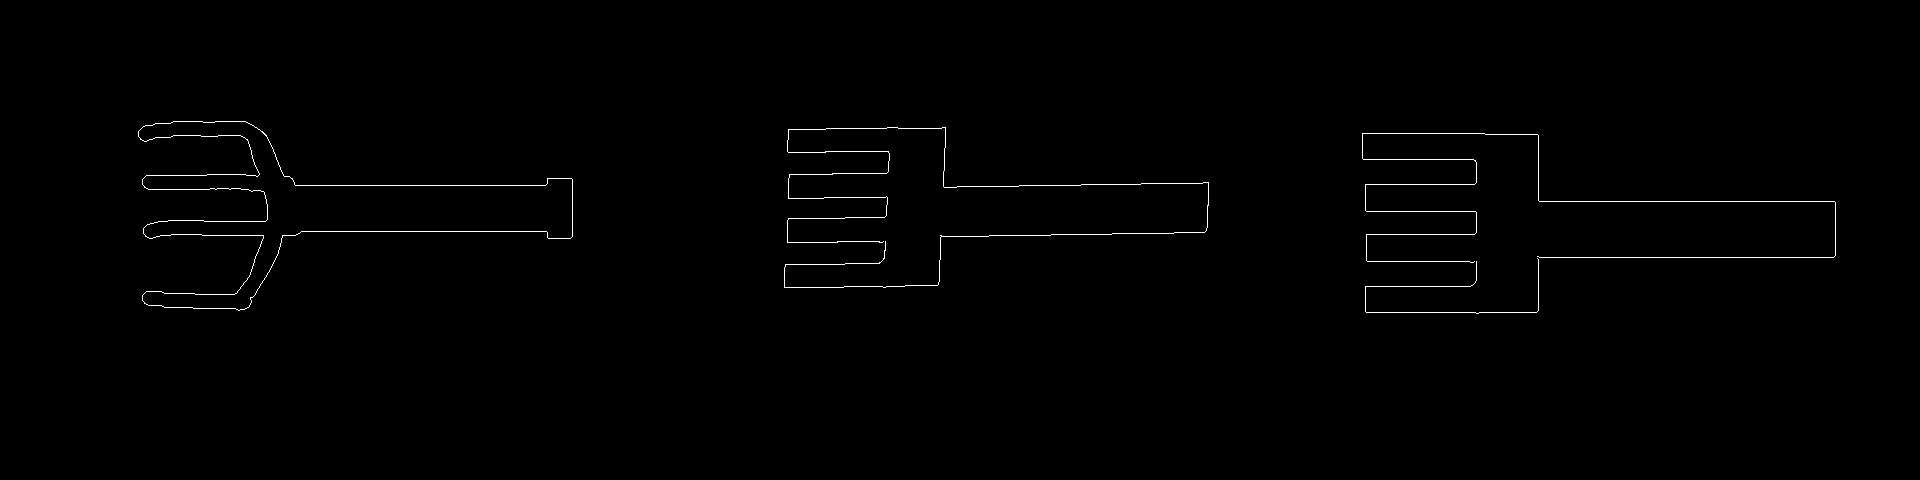

Final error for best match = 367.2380799741894
Execution time = 100.8610589504242 seconds

Results for hammer :



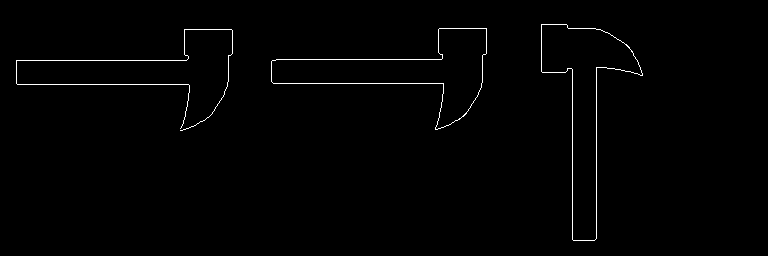

Final error for best match = 163.77288749450878
Execution time = 24.04510498046875 seconds

Results for Heart :



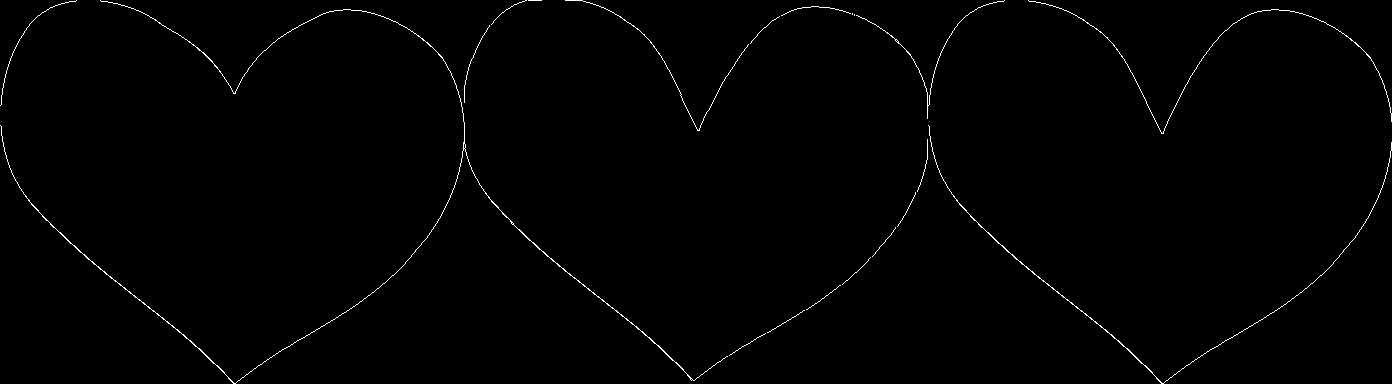

Final error for best match = 312.2067446192426
Execution time = 58.40803599357605 seconds

Results for horse :



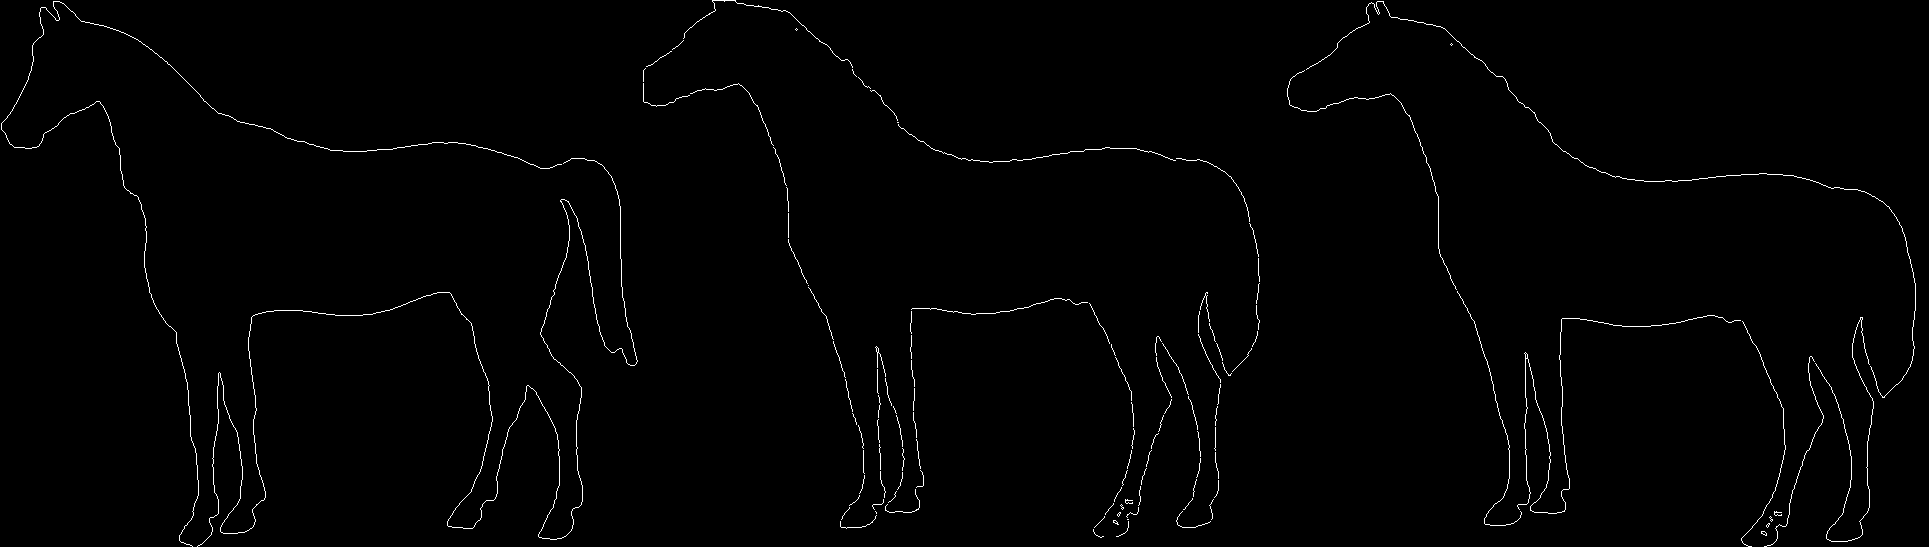

Final error for best match = 491.8015753010094
Execution time = 247.74140763282776 seconds

Results for jar :



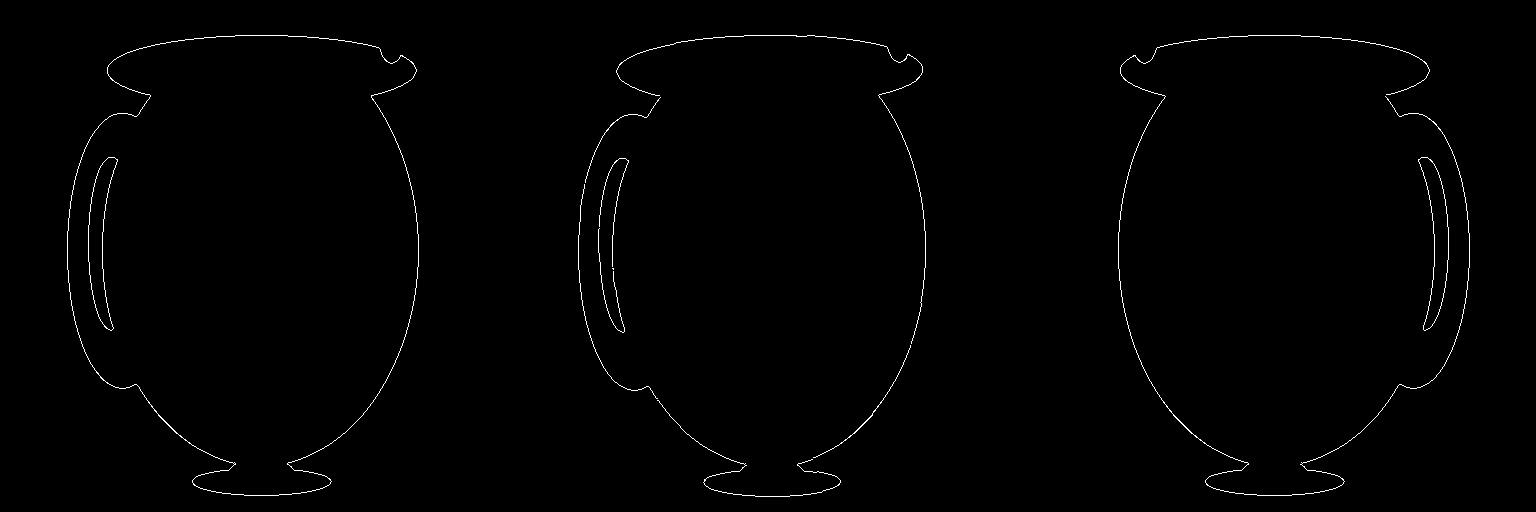

Final error for best match = 363.9749255207572
Execution time = 100.71240258216858 seconds

Results for turtle :



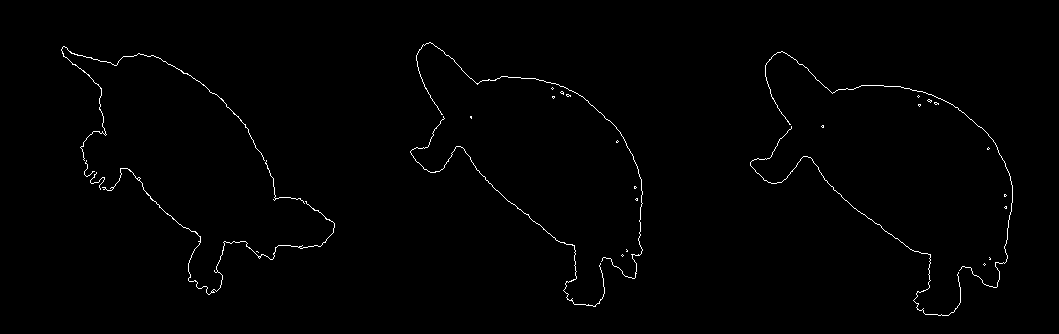

Final error for best match = 258.59629499610134
Execution time = 47.77644348144531 seconds


In [ ]:
# Add code to run align_shape() and display the results and the errors
# YOUR CODE HERE

print("Visualizing the transformation results.\nLeft is the objective image, middle is the transformed image, right is the input image.")
for i in range(numObj):
  print("\nResults for " + objList[i] + " :\n")
  im1 = cv2.imread(imgPath + objList[i] +"_1.png", cv2.IMREAD_GRAYSCALE)
  im2 = cv2.imread(imgPath + objList[i] +"_2.png", cv2.IMREAD_GRAYSCALE)
  align_shape(im1,im2)

**Write-up**

1. Brief explanation of the transformation technique:
- The transformation algorithm that I have used is the Iterative Closest Point (ICP) algorithm. Here we try to optimize for a transformation matrix by creating ground truth from the objective images (image2). For each point in the input image (image1), ground truth is created by finding the corresponding closest point in image2. These closest points are iteratively updated in a loop after transforming the image1 by using the intermediate transformation matrices.
- Three steps were involved in the initialization process: i) The input image and the objective image's centre of masses and the relative scale differences were found. Image1 was scaled to match the size of image2. Both image1 and image2 were translated to the origin for normalization and avoiding possible errors. ii) Since the ICP is not a learning algorithm, if not for a number of initializations, the transformation matrix will get stuck at a local maximum. The input image was rotated by 3 different rotations and mirrored about the origin, hence giving rise to 6 possible combinations of initialization. iii) Post finding out the transformation matrix using ICP, image1 was translated to the Centre of Mass of image2.
- I have coded for both Affine and Perspective transformation models, bearing 6 degrees and 8 degrees of freedom respectively. Affine can capture only translations and rotations, whereas perspective model can capture skewing in addition to translations and rotations. For the results shown above, Perspective model has been used. To choose the best result out of the 6 possible combinations, I have written an error() function which calculates the mean error by using the closest neighbor approach.

2. The results of all the pairs of images have been shown above. However the error function provided to us seems kind of ambiguous, since it wasn't able to capture the difference between good and bad matches. Hence I wrote my own error function based on closest neighbours to rate the transformation and choose the best one out of the different initialization results. However, the result for error displayed above is by using the provided evalAlignment() function. The overall runtime spanning all the images however went over 30 minutes owing to checking 6 hypotheses for every pair.
